In [1]:
import sys

sys.path.append("..")
sys.path.append("../..")
sys.path.append("../../src")

import main
import os
import jax
import matplotlib.pyplot as plt
from functional_autoencoders.util import yaml_load, pickle_load
from util_exp import get_mse_losses_per_quantity_over_time
from plots import set_plot_style_publication, plot_wallclock
from plots_sde1d import (
    plot_potential_and_samples,
    plot_reconstructions_and_generated_samples,
    plot_latent_variable,
    plot_transition_time_distribution,
)

# %reload_ext autoreload
# %autoreload 2

key = jax.random.PRNGKey(42)

In [2]:
MODEL_OUT_DIR = "../../tmp/experiments/exp_sde1d/models"
CONFIG_PATH = "../configs/config_sde1d.yaml"

N_DATA_SAMPLES = 2**14

set_plot_style_publication()

config_sde1d = yaml_load(CONFIG_PATH)
config_data = config_sde1d["data"]

_, test_dataloader = main.get_sde_dataloaders(
    config_data, verbose=True, samples=N_DATA_SAMPLES, which="test"
)

info_per_theta = {}
for theta in os.listdir(MODEL_OUT_DIR):
    info_per_theta[float(theta)] = pickle_load(
        os.path.join(MODEL_OUT_DIR, theta, "model.pkl")
    )

  0%|          | 0/40960 [00:00<?, ?it/s]

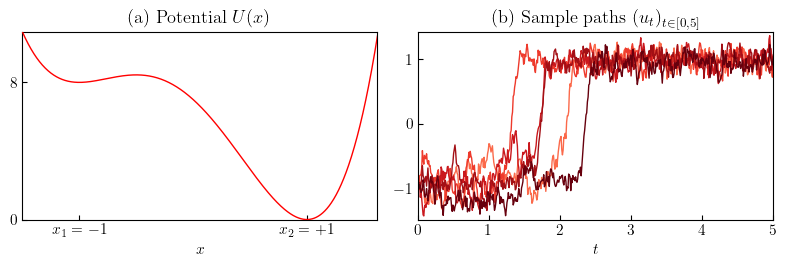

In [3]:
N_SAMPLES = 5

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde1d'
# os.makedirs(SAVE_DIR, exist_ok=True)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_potential_and_samples(ax1, ax2, main.potential_1d, test_dataloader, N_SAMPLES)
fig.set_size_inches(8, 2.8)
fig.tight_layout()
if SAVE_DIR is not None:
    fig.savefig(f"{SAVE_DIR}/sde_potential_and_sample_paths.pdf")

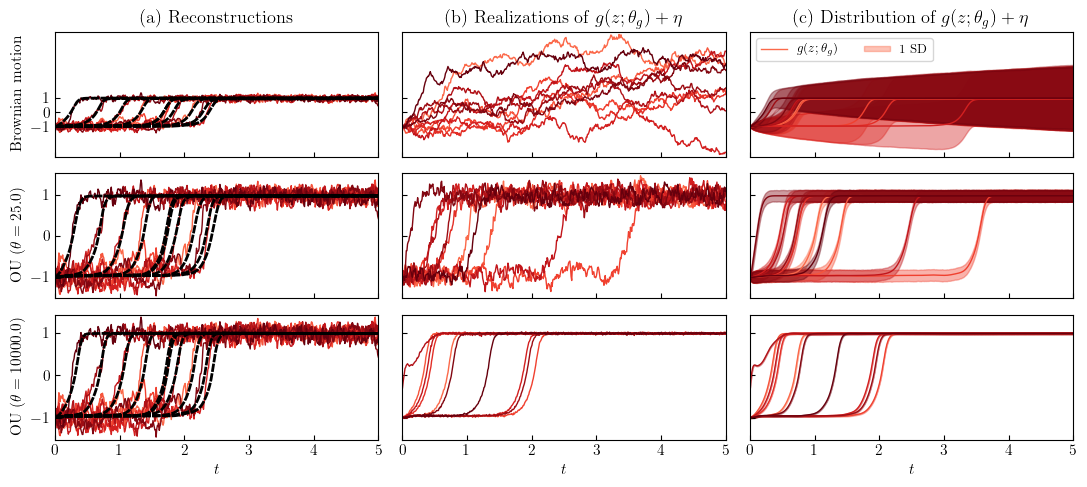

In [4]:
N_SAMPLES = 10

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde1d'
# os.makedirs(SAVE_DIR, exist_ok=True)

fig, axs = plt.subplots(
    len(info_per_theta), 3, sharex=True, sharey="row", squeeze=False
)
for i, (theta, info) in enumerate(sorted(info_per_theta.items())):
    ax1, ax2, ax3 = axs[i, 0], axs[i, 1], axs[i, 2]
    key, subkey = jax.random.split(key)
    plot_reconstructions_and_generated_samples(
        subkey,
        ax1,
        ax2,
        ax3,
        info,
        theta,
        config_data,
        test_dataloader,
        n_samples=N_SAMPLES,
        title=(i == 0),
    )
    ax1.set_ylabel("Brownian motion" if theta == 0 else f"OU ($\\theta = {theta}$)")
    if i == 0:
        ax3.legend(
            loc="upper left",
            ncol=len(info_per_theta),
            fontsize="small",
            handleheight=0.3,
        )

ax1.set_xlabel("$t$")
ax2.set_xlabel("$t$")
ax3.set_xlabel("$t$")
fig.set_size_inches(11, 5)
fig.tight_layout()

if SAVE_DIR is not None:
    fig.savefig(f"{SAVE_DIR}/sde_reconstructions_and_samples.pdf")

In [5]:
data_output_dir = f"../../tmp/experiments/exp_sde1d/data/"
mse_test_losses_per_theta_over_time = get_mse_losses_per_quantity_over_time(data_output_dir, "theta")

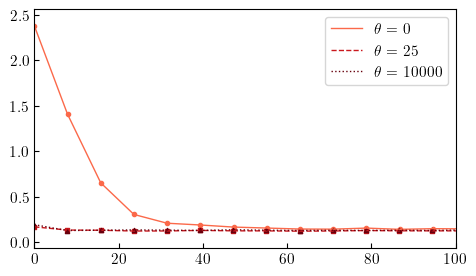

In [6]:
SAVE_DIR = None
# SAVE_DIR = '../../figures/sde1d'
# os.makedirs(SAVE_DIR, exist_ok=True)

set_plot_style_publication()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4.9, 2.9)
plot_wallclock(
    ax=ax, 
    losses=mse_test_losses_per_theta_over_time, 
    right_lim=100,
    label_fn=lambda theta: rf'$\theta$ = {int(theta)}',
)
ax.legend()

if SAVE_DIR is not None:
    plt.savefig(f"{SAVE_DIR}/sde1d_wallclock.pdf")
    plt.close()
else:
    plt.tight_layout()
    plt.show()

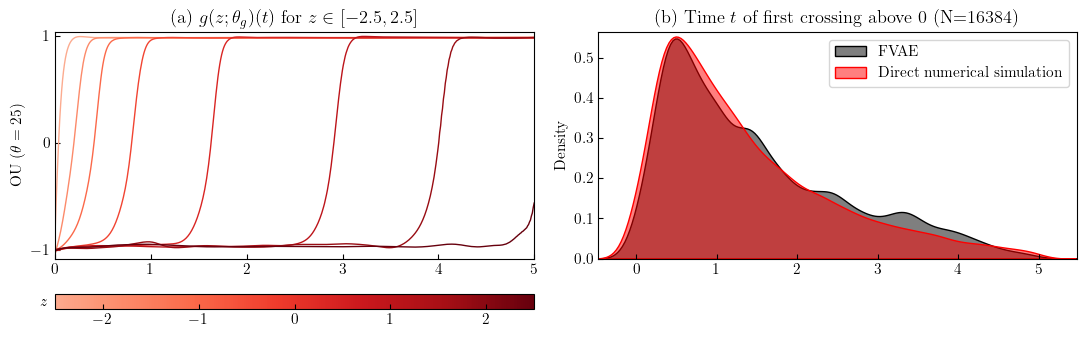

In [7]:
LATENT_VARIABLE_THETA = 25

SAVE_DIR = None
# SAVE_DIR = '../../figures/sde1d'
# os.makedirs(SAVE_DIR, exist_ok=True)

fig, ((ax1, ax2), (ax_colorbar, _)) = plt.subplots(
    2, 2, gridspec_kw={"height_ratios": [15, 1]}
)
plot_latent_variable(
    ax1, ax_colorbar, info_per_theta[LATENT_VARIABLE_THETA], test_dataloader
)

key, subkey = jax.random.split(key)
plot_transition_time_distribution(
    subkey, ax2, info_per_theta[LATENT_VARIABLE_THETA], test_dataloader
)
ax1.set_ylabel(
    "Brownian motion" if theta == 0 else f"OU ($\\theta = {LATENT_VARIABLE_THETA}$)"
)
_.remove()
fig.set_size_inches(11, 3.5)
fig.tight_layout()
if SAVE_DIR is not None:
    fig.savefig(f"{SAVE_DIR}/sde_latent_variables.pdf")